In [2]:
# Loading data from Kaggle
import kagglehub
gan_getting_started_path = kagglehub.competition_download('mushroom-multiclass-classification')

print('Data source import complete.')

100%|██████████| 32.5M/32.5M [00:00<00:00, 74.6MB/s]

Extracting files...


Data source import complete.


<font color = 'blue'>
<font color = 'blue'>
In this project, we have to classify 10 different types of mushrooms found in Estonia. We have about 2500 images of mushrooms and their associated labels. Besides, we have about 500 images in the test set on which we have to make predictions to assess our model. I have taken the dataset from a Kaggle competition, so to get the results on the test datset, we have to submit the predictions to Kaggle.

Here is the link to the Kaggle competition and the dataset: <a>https://www.kaggle.com/competitions/mushroom-multiclass-classification/overview</a>

Below is a link to the Github repository where I have stored the notebook for public access.
<a>https://github.com/pgupta7/Mushroom_multiclass_classification</a>

In [3]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
from IPython.display import clear_output
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetV2B3, Xception
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split

import kaggle

## Exploratory data analysis

In [4]:
df = pd.read_csv(gan_getting_started_path + '/train.csv', dtype = {'Image': np.str_})
df.head()

,Image,Mushroom
0,00001,0
1,00002,0
2,00003,0
3,00004,0
4,00005,0


<font color = 'blue'>
The train.csv files contains two columns. The Image column contains the name of the image files of each mushroom and the Mushroom column contains the associated labels. We will use the names of the image files from the Image column to load the corresponding images in the subsequent cells. Finally, we will create a dataset with the loaded image and the associated label.

In [5]:
df.isna().sum()

,0
Image,0
Mushroom,0


<font color = 'blue'>
No NAN or null values.

<font color = 'blue'>
Number of unique mushroom types.

In [6]:
df['Mushroom'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
len(df['Mushroom'].unique())

10

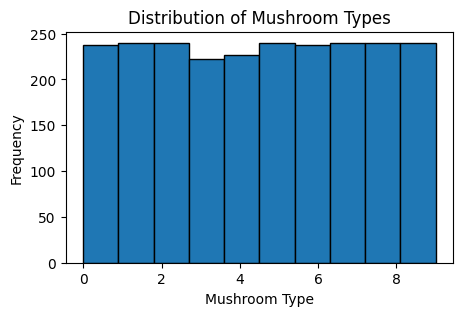

In [ ]:
df['Mushroom'].hist(figsize=(5, 3), edgecolor = 'black', grid= False)
plt.xlabel('Mushroom Type')
plt.ylabel('Frequency')
plt.title('Distribution of Mushroom Types')
plt.show()


<font color = 'blue'>
The above plot shows that the dataset contains the uniformaly distributed mushroom types.

In [ ]:
def loadImagesdummy(filename):
  image = cv2.imread(gan_getting_started_path + '/dataset/dataset/' + filename + '.jpg')
  return image

images = list(map(loadImagesdummy, df['Image'][0:5]))

for i in range(len(images)):
  print(images[i].shape)

(268, 188, 3)
(259, 194, 3)
(194, 259, 3)
(275, 183, 3)
(177, 284, 3)


<font color = 'blue'>
Above, we loaded a few images from the training set, and we can see that the images are all of different sizes. To train a neural network, we will have to resize each of these images to an identical size.

<font color = 'blue'>
Below, we plot the images we loaded above, and again we can clearly see their different sizes.

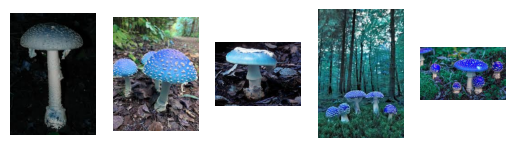

In [ ]:
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(images[i])
  plt.axis('off')
plt.show()


<font color = 'blue'>
Below we check the shapes of all the images in the dataset. We can see that more than 95% of images have less than 300 pixels along either direction, i.e., x and y. Besides, the plot below shows the cumulative distribution of number of pixels along each direction, again showing the majority of distribution below 300 pixels in either direction.

In [ ]:
image_shapes = list(map(lambda x: loadImagesdummy(x).shape, df['Image']))

In [ ]:
x_dim = np.array(list(map(lambda x: x[0], image_shapes)))
y_dim = np.array(list(map(lambda x: x[1], image_shapes)))

In [ ]:
print('minimum number of x pixels', np.min(x_dim))
print('minimum number of y pixels', np.min(y_dim))
print('maximum number of x pixels', np.max(x_dim))
print('maximum number of y pixels', np.max(y_dim))

minimum number of x pixels 112
minimum number of y pixels 142
maximum number of x pixels 1096
maximum number of y pixels 1640


In [ ]:
print('95th percentile along x direction', np.quantile(x_dim, 0.95), 'pixels')
print('95th percentile along y direction', np.quantile(y_dim, 0.95), 'pixels')

95th percentile along x direction 275.0 pixels
95th percentile along y direction 299.0 pixels


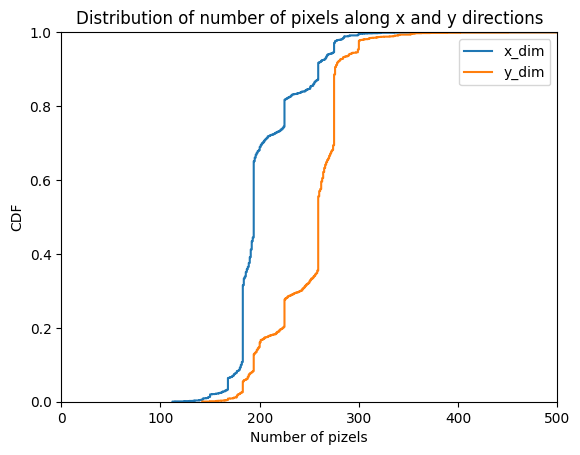

In [ ]:
plt.ecdf(x_dim, label = 'x_dim')
plt.ecdf(y_dim, label = 'y_dim')
plt.xlabel('Number of pizels')
plt.ylabel('CDF')
plt.title('Distribution of number of pixels along x and y directions')
plt.legend()
plt.xlim(0, 500)
plt.show()

## Data analysis methodology

<font color = 'blue'>
This project requires classifying mushrooms into ten different categories, where each image has about 90K pixels. Thus, we use transfer learning rather training a model from scratch. We will use a pretrained model and further optimize the results via training.

<font color = 'blue'>
As our first approach, we will use a pretrained model called
EfficientNetV2B3. It has been trained on ImageNet, and we will use its pretrained weights for our analysis. EfficientNetV2B3 requires input in the shape of (300, 300, 3), and we will hence rescale all the images in our training and test sets to the aforementioned dimensions.

## Data preprocessing

<font color = 'blue'>
We will load the images below into a Tensorflow dataset. For this project, I have decided to use Tensorflow dataset for training purposes rather than the Numpy arrays because of the ease of parallelizing its computations and for performace gains while using GPUs.

<font color = 'blue'>
Next, we will split the data into a training set and a validation set. We will use the validation set to test the Model at the intermediate epochs while training.

In [ ]:
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = (300,300,3)

<font color = 'blue'>
Below is a helper function to load images and convert them to an appropriate format suitable for EfficientNetV2B3.

In [ ]:
path = gan_getting_started_path + '/'
def load_image(filename, label = None):
  image = tf.io.read_file(path + 'dataset/dataset/' + filename + '.jpg')
  image = tf.io.decode_image(image, channels=3, expand_animations=False)

  image = tf.image.resize(image, size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
  image = tf.cast(image, tf.float32)
  if label is None:
    return image
  else:
    return image, label

<font color = 'blue'>
Here, we load the data into train and validation data sets in the suitable form. We will use the valid_ds for validation during the training of a neural net.

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train["Image"], df_train["Mushroom"]))
train_ds = train_ds.map( load_image, num_parallel_calls=-1).batch(BATCH_SIZE).prefetch(-1)

In [ ]:
valid_ds = tf.data.Dataset.from_tensor_slices((df_valid["Image"], df_valid["Mushroom"]))
valid_ds = valid_ds.map( load_image, num_parallel_calls = -1).batch(BATCH_SIZE).prefetch(-1)

<font color = 'blue'>
We next plot the images in the training dataset that we have rescaled to the dimension of (300, 300, 3).


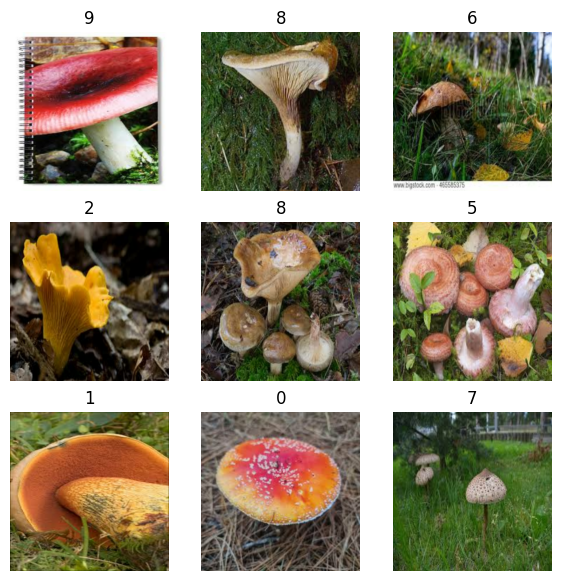

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images from the training dataset
image_batch, label_batch = next(iter(train_ds))

# Plot the images
plt.figure(figsize=(7, 7))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(label_batch[i].numpy())
    plt.axis("off")
plt.show()


<font color = 'blue'>
I have taken the data from a Kaggle competition. So the data comes with its own test set. I will use the test set to do predictions on a trained model. I will submit the predictions in a suitable format to Kaggle and report the test dataset accuracy.

In [ ]:
# loading test.csv file containing the names of images stored in the test folder.
df_test = pd.read_csv(gan_getting_started_path + '/test.csv', dtype = {'Image': np.str_})
df_test.head()

,Image
0,02372
1,02373
2,02374
3,02375
4,02376


In [ ]:
# loading the test images in a Tensorflow datset format in the variable test_ds
test_ds = tf.data.Dataset.from_tensor_slices(df_test["Image"])
test_ds = test_ds.map( load_image, num_parallel_calls=-1).batch(BATCH_SIZE).prefetch(-1)

In [ ]:
test_ds

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None)>

In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Data Analysis

<font color = 'blue'>
First, we will explore a neural network where we use EfficientNetV2B3 as our base model; however, we will keep its weight fixed, i.e., non-trainable. We will add a few layers after the base model whose weights we will train during the training process.

## Model with fixed parameters

<font color = 'blue'>
Below, we create a model based on EfficientNetV2B3 but with its weights fixed, i.e., non-trainable.

In [ ]:
input_shape = IMAGE_SIZE # appropriate with the input data

# loading the EfficientNetV2B3 model
base_model = EfficientNetV2B3(weights='imagenet', include_top = True,\
pooling = 'avg', input_shape = input_shape)
base_model.trainable = False  # Making the weights of the base model non-trainable

# Model
model_fixedParams = keras.Sequential([
    layers.Input(shape=input_shape),
    base_model,
    layers.BatchNormalization(),  # batch normalization
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-3)),
    # dense layer using a L!L2 regularizer
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax') # An output layer consisting of 10 nodes for
    # 10 different categories
])

# Since there are 10 labels, i.e., more than 2, and the labels are not in the one-hot encoded
# form, we use SparseCategoricalCrossentropy and SparseCategoricalAccuracy as our loss and metric,
# respectively.
model_fixedParams.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model_fixedParams.optimizer = Adam(learning_rate= 0.01)

model_fixedParams.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b3 (Functional)  │ (None, 1000)           │    14,467,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,989,264 (57.18 MB)

 Trainable params: 519,642 (1.98 MB)

 Non-trainable params: 14,469,622 (55.20 MB)

<font color = 'blue'>
Here, we note that there are 10 labels, i.e., more than two, and we have not converted the labels to the one-hot encoded form, and hence we use SparseCategoricalCrossentropy and SparseCategoricalAccuracy as our loss and metric, respectively. There are proxies for Categorical entropy and accuracy, but they work with the integer-coded labels.

<font color = 'blue'>
Further, we will use two callbacks for early stopping and for reducing the learning rate further in the training. They both will be based on monitoring validation losses.

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

<font color = 'blue'>
Model training:

In [ ]:
hist_fixedParams = model_fixedParams.fit(train_ds, validation_data= valid_ds, epochs=50, callbacks=[es, reduce_lr])

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 2.3061 - sparse_categorical_accuracy: 0.2926 - val_loss: 2.2984 - val_sparse_categorical_accuracy: 0.2706 - learning_rate: 0.0100
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 1.8777 - sparse_categorical_accuracy: 0.4091 - val_loss: 2.2719 - val_sparse_categorical_accuracy: 0.3171 - learning_rate: 0.0100
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 1.8801 - sparse_categorical_accuracy: 0.4438 - val_loss: 2.2707 - val_sparse_categorical_accuracy: 0.3256 - learning_rate: 0.0100
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 1.9391 - sparse_categorical_accuracy: 0.4255 - val_loss: 2.2169 - val_sparse_categorical_accuracy: 0.3721 - learning_rate: 0.0100
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 1.9218 - sparse_categorical_accuracy: 0.4372 - val_loss: 2.2581 - val_sparse_categorical_accuracy: 0.3362 - learning_rate: 0.0100
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step 

<font color = 'blue'>
Here is a helper function to plot the histroy of the trained model

In [ ]:
# Helper function to plot the histroy of the trained model
def plothistory(hist1, keys):
  fig, ax= plt.subplots(1, 2, figsize=(10, 4))
  for i in range(len(keys)):
    ax[i].plot(hist1.history[keys[i]], label = 'Train')
    ax[i].plot(hist1.history['val_' + keys[i]], label = 'Validation set')
    # ax[i].set_title('Model loss')
    ax[i].set_ylabel(keys[i])
    ax[i].set_xlabel('Epoch')
    ax[i].legend(loc='upper right')
  plt.show()

<font color = 'blue'>
Below, we plot the loss and accuracy history of the trained model at various epochs.

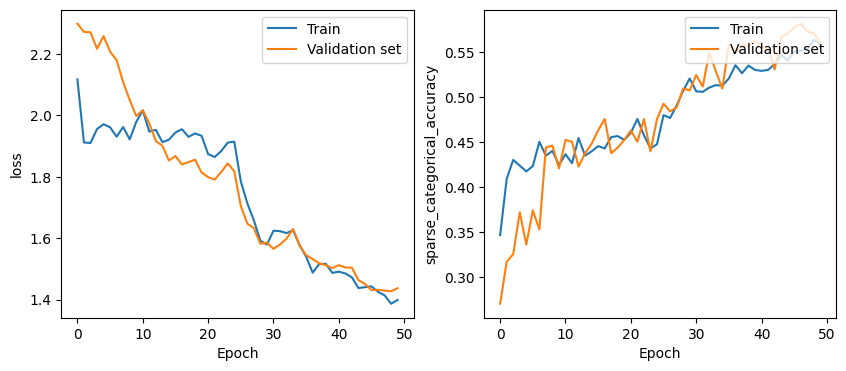

In [ ]:
plothistory(hist_fixedParams, ['loss', 'sparse_categorical_accuracy'])

<font color = 'blue'>
As mentioned at the beginning of the document, I took the data from a Kaggle competition, which has its own test set. We will predict labels for this test set using our trained model, upload the results to Kaggle, and then extract the accuracy score from the Kaggle website.<br> Below, we have helper functions to do all this.

In [ ]:
# predicting on the test dataset
def predictOnTeset(model):
    res = model.predict(test_ds)
    res = np.argmax(res, axis = 1)
    return res

# Creating and uploading a test result csv file to Kaggle
def createFileAndUploadToKaggle(filename, predictions):
    path = gan_getting_started_path + '/output/'
    os.makedirs(path, exist_ok=True)
    pd.DataFrame({'Id': list(range(len(df_test['Image']))), 'target':predictions}).to_csv(path + filename, index= False)
    kaggle.api.authenticate()
    subms = kaggle.api.competition_submit(path + filename,'ghhb','mushroom-multiclass-classification')
    return subms

# Obtaining score on the test dataset from Kaggle
def getKaggleScore(subms):
    kaggle.api.authenticate()
    sublist = kaggle.api.competition_submissions('mushroom-multiclass-classification')
    # print(subms.ref)
    for sub in sublist:
        if(sub.ref == subms.ref):
            print('The accuracy score is', sub.public_score)
            return sub.public_score

<font color = 'blue'>
Below, we predict the labels on the test set using the model we trained and upload it to Kaggle.

In [ ]:
res = predictOnTeset(model_fixedParams)
subms = createFileAndUploadToKaggle('model_fixedParams.csv', res)

10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


100%|██████████| 3.41k/3.41k [00:00<00:00, 4.48kB/s]


<font color = 'blue'>
We have the accuracy score on the test datset below, obtained from Kaggle.

In [ ]:
score = getKaggleScore(subms)

The accuracy score is 0.54180


## Model updating 10% of EfficientNetV2B3 parameters

<font color = 'blue'>
Next, we make another model, where we will keep about 10% of the model EfficientNetV2B3 trainable, while keeping 90% as fixed, thus giving us more freedom to tune parameters. Again, we will have batch normalization, dense, and dropout layers following the Imagenet model.

In [ ]:
input_shape = (300, 300, 3) # appropriate with the input data
base_model = EfficientNetV2B3(weights='imagenet', include_top = True,\
pooling = 'avg', input_shape = input_shape)

# Ensuring that 90% of model parameters are non-trainable, leaving only 10% as trainable.
base_model.trainable = False
for layer in base_model.layers[int(len(base_model.layers)*0.9):]:
  layer.trainable = True

# creating the model
model_updateParams = keras.Sequential([
    layers.Input(shape=input_shape),
    base_model,
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-3)),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# compiling the model with loss, metrics, and an optimizer.
model_updateParams.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model_updateParams.optimizer = Adam(learning_rate= 0.01)

model_updateParams.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b3 (Functional)  │ (None, 1000)           │    14,467,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,989,264 (57.18 MB)

 Trainable params: 4,476,342 (17.08 MB)

 Non-trainable params: 10,512,922 (40.10 MB)

In [ ]:
hist_updateParams = model_updateParams.fit(train_ds, validation_data= valid_ds, epochs=50, callbacks=[es, reduce_lr])

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - loss: 2.3409 - sparse_categorical_accuracy: 0.4135 - val_loss: 2.2851 - val_sparse_categorical_accuracy: 0.5328 - learning_rate: 0.0100
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 1.5484 - sparse_categorical_accuracy: 0.6498 - val_loss: 2.0525 - val_sparse_categorical_accuracy: 0.6025 - learning_rate: 0.0100
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 1.2279 - sparse_categorical_accuracy: 0.7287 - val_loss: 1.7620 - val_sparse_categorical_accuracy: 0.6427 - learning_rate: 0.0100
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 1.2357 - sparse_categorical_accuracy: 0.7277 - val_loss: 1.6197 - val_sparse_categorical_accuracy: 0.6237 - learning_rate: 0.0100
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 1.2067 - sparse_categorical_accuracy: 0.7030 - val_loss: 1.2819 - val_sparse_categorical_accuracy: 0.7209 - learning_rate: 0.0100
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step 

<font color = 'blue'>
Plotting the model history.

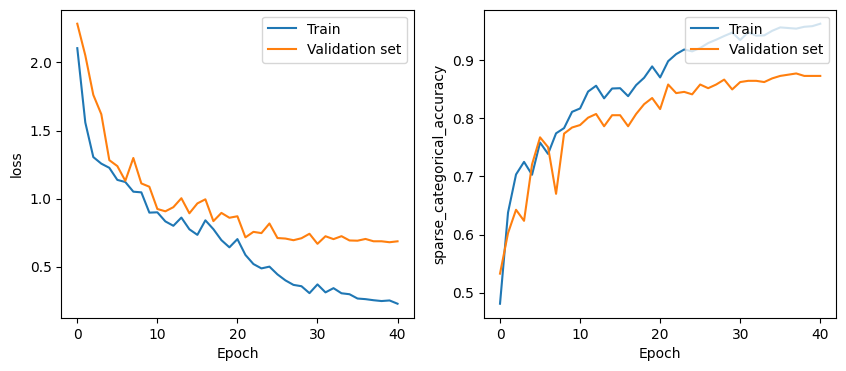

In [ ]:
plothistory(hist_updateParams, ['loss', 'sparse_categorical_accuracy'])

<font color = 'blue'>
Predicting on the test set, uploading the results to Kaggle, and obtaining accuracy from the Kaggle website.

In [ ]:
res = predictOnTeset(model_updateParams)

10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


In [ ]:
subms = createFileAndUploadToKaggle('model_updateParams.csv', res)

100%|██████████| 3.41k/3.41k [00:00<00:00, 4.57kB/s]


In [ ]:
score = getKaggleScore(subms)

The accuracy score is 0.86622


## Model with data augmentation

<font color = 'blue'>
Below, we create a model with data augmentation. Data augmentation can help us train a model that could take into account small changes in the position and contrast of the content of the images.
We augment the data with the following additions: Random flip, random zoom, random contrast, and a random Guassian noise. Although there are more ways to make changes to images, we will for now stick to these only.

In [ ]:
input_shape = (300, 300, 3) # appropriate with the input data
base_model = EfficientNetV2B3(weights='imagenet', include_top = True,\
pooling = 'avg', input_shape = input_shape)
base_model.trainable = False
for layer in base_model.layers[int(len(base_model.layers)*0.9):]:
  layer.trainable = True

# Data augmentation
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.GaussianNoise(0.02),
    ], name='augmentation')


model_Withaugmentation = keras.Sequential([
    layers.Input(shape=input_shape),
    data_augmentation,  #adding data augmentation layers
    base_model,
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-3)),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model_Withaugmentation.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model_Withaugmentation.optimizer = Adam(learning_rate= 0.01)

model_Withaugmentation.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 1000)           │    14,467,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,989,264 (57.18 MB)

 Trainable params: 4,476,342 (17.08 MB)

 Non-trainable params: 10,512,922 (40.10 MB)

In [ ]:
hist_withAugmentation = model_Withaugmentation.fit(train_ds, validation_data= valid_ds, epochs=50, callbacks=[es, reduce_lr])

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 527ms/step - loss: 2.3755 - sparse_categorical_accuracy: 0.3908 - val_loss: 2.4522 - val_sparse_categorical_accuracy: 0.3510 - learning_rate: 0.0100
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step - loss: 1.5267 - sparse_categorical_accuracy: 0.6589 - val_loss: 2.0471 - val_sparse_categorical_accuracy: 0.5962 - learning_rate: 0.0100
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - loss: 1.4421 - sparse_categorical_accuracy: 0.6579 - val_loss: 1.7307 - val_sparse_categorical_accuracy: 0.7061 - learning_rate: 0.0100
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 301ms/step - loss: 1.3738 - sparse_categorical_accuracy: 0.7098 - val_loss: 1.7601 - val_sparse_categorical_accuracy: 0.6004 - learning_rate: 0.0100
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/step - loss: 1.4001 - sparse_categorical_accuracy: 0.6944 - val_loss: 1.5245 - val_sparse_categorical_accuracy: 0.6216 - learning_rate: 0.0100
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 307ms/st

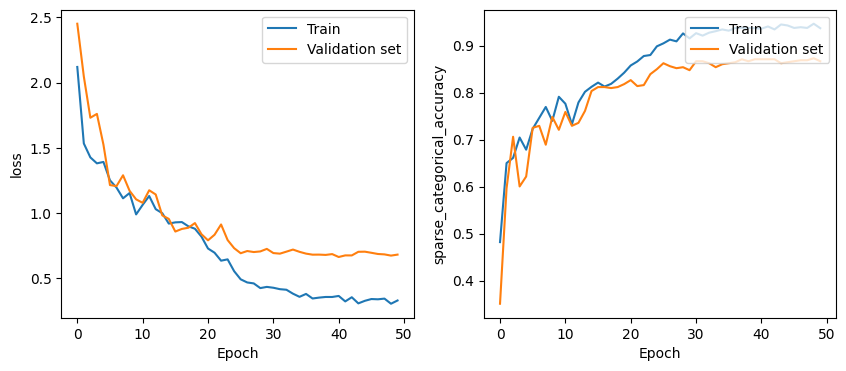

In [ ]:
plothistory(hist_withAugmentation, ['loss', 'sparse_categorical_accuracy'])

In [ ]:
res = predictOnTeset(model_Withaugmentation)
subms = createFileAndUploadToKaggle('model_Withaugmentation.csv', res)

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 666ms/step


100%|██████████| 3.41k/3.41k [00:00<00:00, 4.48kB/s]


In [ ]:
score = getKaggleScore(subms)

The accuracy score is 0.86622


<font color = 'blue'>
We note that we received the same test set accuracy as the model with no data augmentation. However, with data augmentation, there is a still a possibility that this model is more robust to tiny variations in images and hence may give better accuracies with more diverse test sets.

<font color = 'blue'>
Next, we will use transfer learning from a different model, called Xception. Although it is also trained on Imagenet, same as the EfficeintNetV2B3 model, it has a different architecture from the EfficeintNetV2B3 model.

## Model with Xception as the base model

<font color = 'blue'>
As our first base model, we will keep the parameters of the Xception model as non-trainable. I will also add a data augmentation layer to the following models, similar to what we did with earlier models.

<font color = 'blue'>
First, we pre-process the training, validation, and the test datasets to map them to an appropriate format suitable for using on the Xception model. Moreover, the Xception model requires input images with dimensions 299 X 299, so we will convert them to the suitable size.

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input
train_ds = train_ds.map(lambda x, y: (preprocess_input(tf.image.resize(x, size=(299, 299))), y))
valid_ds = valid_ds.map(lambda x, y: (preprocess_input(tf.image.resize(x, size=(299, 299))), y))

In [ ]:
test_ds = test_ds.map(lambda x: (preprocess_input(tf.image.resize(x, size=(299, 299)))))

In [ ]:
input_shape = (299, 299, 3) # appropriate with the input data
base_model = Xception(weights='imagenet', include_top = False, pooling = 'avg', classes = 10)
base_model.trainable = False

# data augmentation
data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.GaussianNoise(0.02),
    ], name='augmentation')


model_Xception = keras.Sequential([
    layers.Input(shape = input_shape),
    data_augmentation,
    base_model,
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model_Xception.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model_Xception.optimizer = Adam(learning_rate= 0.001)

model_Xception.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,917,746 (83.61 MB)

 Trainable params: 1,055,242 (4.03 MB)

 Non-trainable params: 20,862,504 (79.58 MB)

In [ ]:
hist_Xception = model_Xception.fit(train_ds, validation_data= valid_ds,epochs=50, callbacks=[es, reduce_lr])

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 418ms/step - loss: 2.5018 - sparse_categorical_accuracy: 0.3364 - val_loss: 1.6672 - val_sparse_categorical_accuracy: 0.5328 - learning_rate: 0.0010
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - loss: 1.2024 - sparse_categorical_accuracy: 0.6210 - val_loss: 1.5235 - val_sparse_categorical_accuracy: 0.5349 - learning_rate: 0.0010
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - loss: 1.0005 - sparse_categorical_accuracy: 0.6739 - val_loss: 1.4505 - val_sparse_categorical_accuracy: 0.5011 - learning_rate: 0.0010
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - loss: 0.8781 - sparse_categorical_accuracy: 0.6961 - val_loss: 1.4241 - val_sparse_categorical_accuracy: 0.4926 - learning_rate: 0.0010
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - loss: 0.8378 - sparse_categorical_accuracy: 0.7253 - val_loss: 1.2860 - val_sparse_categorical_accuracy: 0.5624 - learning_rate: 0.0010
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 329

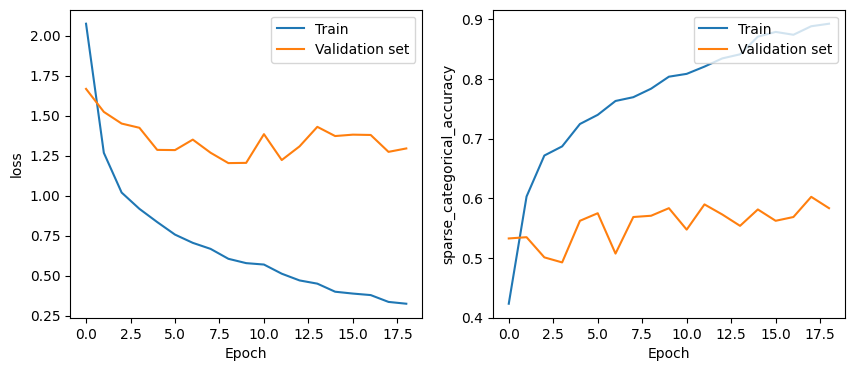

In [ ]:
plothistory(hist_Xception, ['loss', 'sparse_categorical_accuracy'])

In [ ]:
res = predictOnTeset(model_Xception)
subms = createFileAndUploadToKaggle('model_Xception.csv', res)

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 390ms/step


100%|██████████| 3.41k/3.41k [00:00<00:00, 4.42kB/s]


In [ ]:
score = getKaggleScore(subms)

The accuracy score is 0.53846


## Exception model with trainable parameters

<font color = 'blue'>
In this model, we will keep 10% of the parameters from the Xception as trainable, while leaving the remaining 90% as untrainable, giving us freedom to make a the model more accurate.

In [ ]:
input_shape = (299, 299, 3) # appropriate with the input data
base_model = Xception(weights='imagenet', include_top = False, pooling = 'avg', classes = 10)
base_model.trainable = False
for layer in base_model.layers[int(len(base_model.layers)*0.9):]:
  layer.trainable = True

model_XceptionTrainable = keras.Sequential([
    layers.Input(shape = input_shape),
    data_augmentation,
    base_model,
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model_XceptionTrainable.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model_XceptionTrainable.optimizer = Adam(learning_rate= 0.001)

model_XceptionTrainable.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,917,746 (83.61 MB)

 Trainable params: 7,305,634 (27.87 MB)

 Non-trainable params: 14,612,112 (55.74 MB)

In [ ]:
hist_XceptionTrainable = model_XceptionTrainable.fit(train_ds, validation_data= valid_ds,epochs=50,
                                                     callbacks=[es, reduce_lr])

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 538ms/step - loss: 2.1549 - sparse_categorical_accuracy: 0.4048 - val_loss: 2.0566 - val_sparse_categorical_accuracy: 0.4926 - learning_rate: 0.0010
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 399ms/step - loss: 0.9078 - sparse_categorical_accuracy: 0.6940 - val_loss: 1.7063 - val_sparse_categorical_accuracy: 0.4905 - learning_rate: 0.0010
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 399ms/step - loss: 0.6091 - sparse_categorical_accuracy: 0.7959 - val_loss: 1.4304 - val_sparse_categorical_accuracy: 0.6385 - learning_rate: 0.0010
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 398ms/step - loss: 0.4678 - sparse_categorical_accuracy: 0.8411 - val_loss: 1.3967 - val_sparse_categorical_accuracy: 0.5391 - learning_rate: 0.0010
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 393ms/step - loss: 0.3493 - sparse_categorical_accuracy: 0.8890 - val_loss: 1.4141 - val_sparse_categorical_accuracy: 0.4884 - learning_rate: 0.0010
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 396

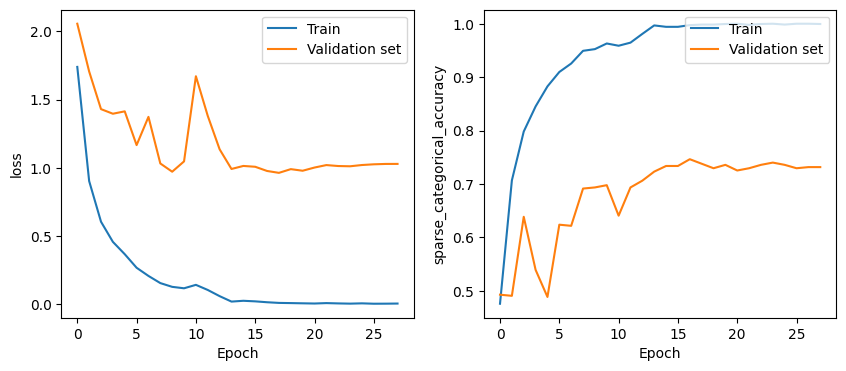

In [ ]:
plothistory(hist_XceptionTrainable, ['loss', 'sparse_categorical_accuracy'])

<font color = 'blue'>
Predicting the test set, submitting the result to Kaggle, and then getting the score on the test set from Kaggle.

In [ ]:
res = predictOnTeset(model_XceptionTrainable)
subms = createFileAndUploadToKaggle('model_XceptionTrainable.csv', res)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step


100%|██████████| 3.41k/3.41k [00:00<00:00, 4.45kB/s]


In [ ]:
score = getKaggleScore(subms)

The accuracy score is 0.70903


## Conclusion

<font color = 'blue'>
The task in this project was to classify mushroom images into 10 different categories. We used transfer learning from two different models, viz., EfficientNetV2B3 and Xception, which have been trained on ImageNet. Using these pre-trained models, we created five different Neural networks and we trained them in different configurations. The table below lists the accuracies we observed on the test set on different models, the predictions for which we submitted to the Kaggle competion.
</font>
</font>
<br><br>
<table>
  <tr>
    <th>Base Mode</th>
    <th>Details</th>
    <th>Score</th>
  </tr>
  <tr>
    <td>EfficientNetV2B3</td>
    <td>Non-trainable parameters</td>
    <td>0.54</td>
  </tr>
  <tr>
    <td>EfficientNetV2B3</td>
    <td>10% trainable parameters</td>
    <td>0.86</td>
  </tr>
  <tr>
    <td>EfficientNetV2B3</td>
    <td>10% trainable parameters and data augmentation</td>
    <td>0.86</td>
  </tr>
  <tr>
    <td>Xception</td>
    <td>non-trainable parameters and data augmentation</td>
    <td>0.54</td>
  </tr>
  <tr>
    <td>Xception</td>
    <td>10% trainable parameters and data augmentation</td>
    <td>0.71</td>
  </tr>
</table>
<br>
<font color = 'blue'>
We can see from the above table that the EfficientNetV2B3 model with 10% trainable parameters performs quite well, both with and without data augmentation. Although Xception model with 10% trainable parameters did relatively better, it still lagged behind EfficientNetV2B3 model with 10% trainable parameters. However, both EfficientNetV2B3 and Xception based models did poorly with non-trainable parameters of their base models, which is not surprising. Moreover, we note that data augmentation may not have provided further accuracy on EfficientNetV2B3, but it is likely that the model became more robust and might perform better on test sets with more diverse data. Beisdes, there is still room to improve the accuracy with the following recommendations:
<ul><font color = 'blue'>
<li>We can add more layers post base-models and train them;</li>
<li>We trained only 10% weights of the pre-trained model, and thus, it would be recommended to train more of their weights;</li>
<li>Data augmentation can further be improved by adding random rotations and translations;</li>
<li>There exist more pretrained models like the ones used in this notebook; we can try them as well.</li>
</ul>